In [1]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 


2024-03-21 19:02:30.978605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
source_dir  = "NewDatasetAugmentedv4"
destination_dir  = "PokerDataset"

In [3]:
# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Iterate through the images in the source directory
for filename in os.listdir(source_dir):
    # Extract the label from the image filename
    label = filename.split('.')[0]  # Assumes label is before the first period
    
    # Create the label directory if it doesn't exist
    label_dir = os.path.join(destination_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    
    # Define the source and destination paths
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(label_dir, filename)
    
    # Move the image to the appropriate label directory
    shutil.move(source_path, destination_path)

print("Directory structure conversion complete.")

Directory structure conversion complete.


In [3]:
DATA_DIR = "PokerDataset"  
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

In [7]:
image_paths = []
labels = []


In [8]:
for label in os.listdir(DATA_DIR):
    label_dir = os.path.join(DATA_DIR, label)
    for image_file in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, image_file))
        labels.append(label)

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=TEST_SIZE, random_state=42, stratify=labels)

In [10]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_val)
y_train_val_encoded = label_encoder.transform(y_train_val)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
# Convert integer labels to categorical format
y_train_val = to_categorical(y_train_val_encoded, NUM_CLASSES)

# Convert integer labels to categorical format
y_test = to_categorical(y_test_encoded, NUM_CLASSES)

In [12]:
# Verify one-hot encoding
print("Shape of y_train_val:", y_train_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train_val: (624, 52)
Shape of y_test: (156, 52)


In [13]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

In [14]:
X_train_val = [preprocess_image(image_path) for image_path in X_train_val]
X_test = [preprocess_image(image_path) for image_path in X_test]

In [15]:
X_train_val = np.array(X_train_val)
X_test = np.array(X_test)

In [14]:
# Save the preprocessed data
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', label_encoder.classes_)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks


In [17]:
model = Sequential()
model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
model.add(Conv2D(8, (3, 3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(Dense(32, activation='relu', name='dense1'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))

2024-03-21 17:19:30.306637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
print("Model summary:")
model.summary()

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 4)         112       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 8)         296       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense1 (Dense)              (None, 32)                50208     
                                                                 
 output (Dense)              (None, 52)  

In [24]:
train = True
if train:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9509
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 2.37232, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 2.37232, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 2s 24ms/step - loss: 0.2320 - accuracy: 0.9509 - val_loss: 2.3723 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 2/50
44/47 [===========================>..] - ETA: 0s - loss: 0.1579 - accuracy: 0.9750
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss did not improve from 2.37232

Epoch 2: val_loss did not improve from 2.37232

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_l

Epoch 16/50
47/47 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 16: val_loss did not improve from 2.37232

Epoch 16: val_loss did not improve from 2.37232

Epoch 16: saving model to model_1/KERAS_check_model_last.h5

Epoch 16: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 17ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 2.8954 - val_accuracy: 0.5577 - lr: 5.0000e-04
Epoch 17/50
45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 17: val_loss did not improve from 2.37232

Epoch 17: val_loss did not improve from 2.37232

Epoch 17: saving model to model_1/KERAS_check_model_last.h5

Epoch 17: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 16ms/step - los


***callbacks end***

47/47 [==============================] - 1s 17ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.0107 - val_accuracy: 0.5577 - lr: 2.5000e-04
Epoch 31/50
43/47 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 31: val_loss did not improve from 2.37232

Epoch 31: val_loss did not improve from 2.37232

Epoch 31: saving model to model_1/KERAS_check_model_last.h5

Epoch 31: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 16ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 3.0206 - val_accuracy: 0.5577 - lr: 2.5000e-04
Epoch 32/50
44/47 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 32: val_loss did not improve from 2.37232

Epoch 32: val_loss did not improve from 2.37232

Epoch 32: saving model to model_1/KERAS_c


Epoch 45: val_loss did not improve from 2.37232

Epoch 45: saving model to model_1/KERAS_check_model_last.h5

Epoch 45: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.0754 - val_accuracy: 0.5577 - lr: 6.2500e-05
Epoch 46/50
43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 46: val_loss did not improve from 2.37232

Epoch 46: val_loss did not improve from 2.37232

Epoch 46: saving model to model_1/KERAS_check_model_last.h5

Epoch 46: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.0753 - val_accuracy: 0.5577 - lr: 6.2500e-05
Epoch 47/50
47/47 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
***callbacks*

5/5 [==============================] - 0s 12ms/step
Accuracy: 0.6025641025641025


/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

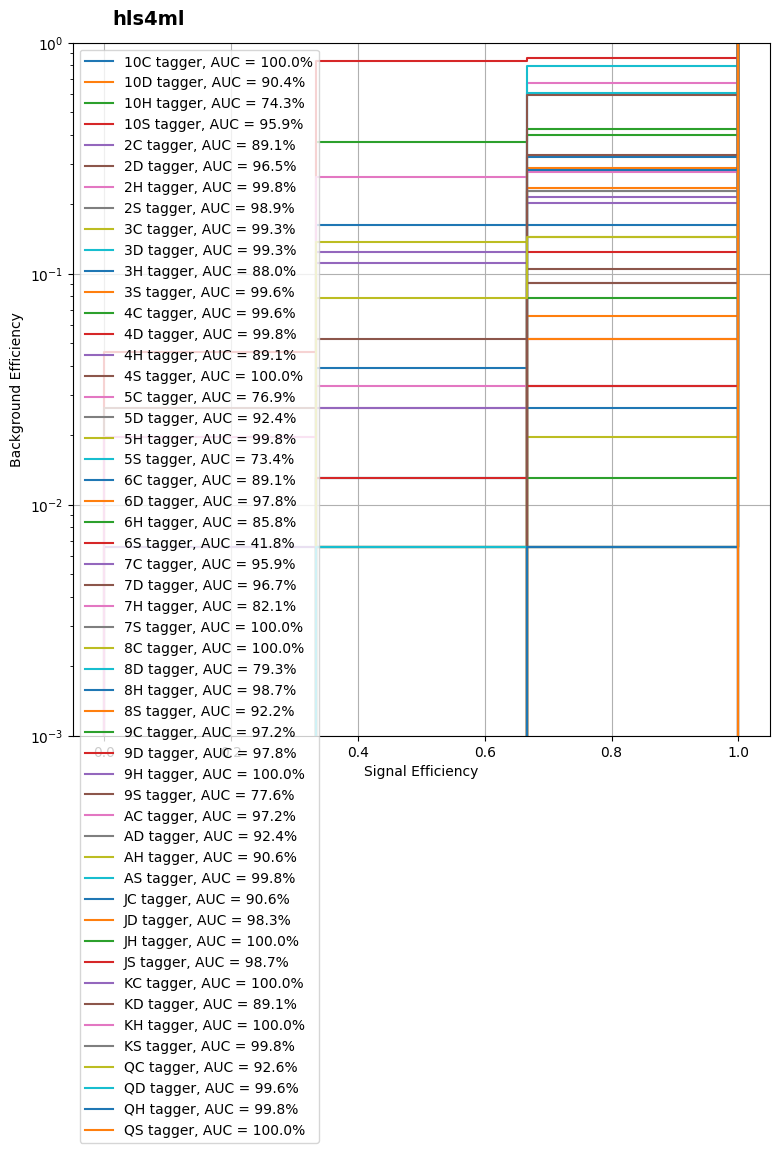

In [25]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)

In [26]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Stra

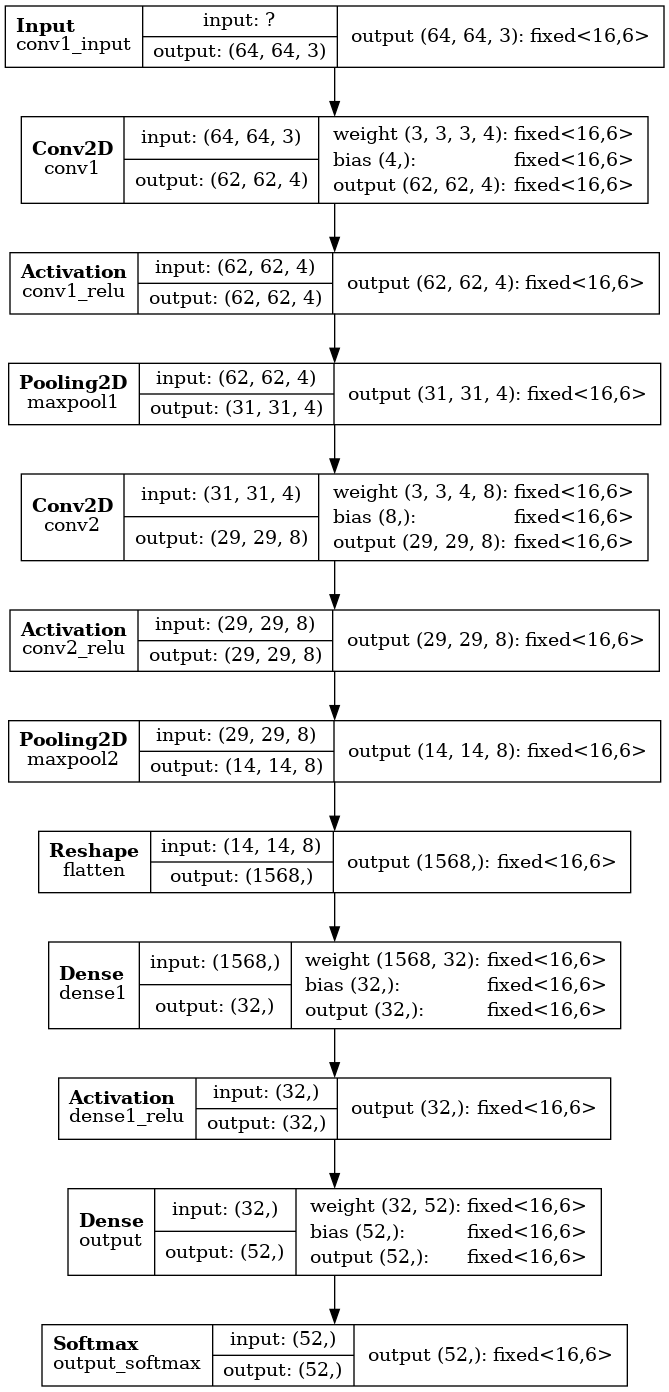

In [27]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [28]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


Keras  Accuracy: 0.6025641025641025
hls4ml Accuracy: 0.28846153846153844


/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

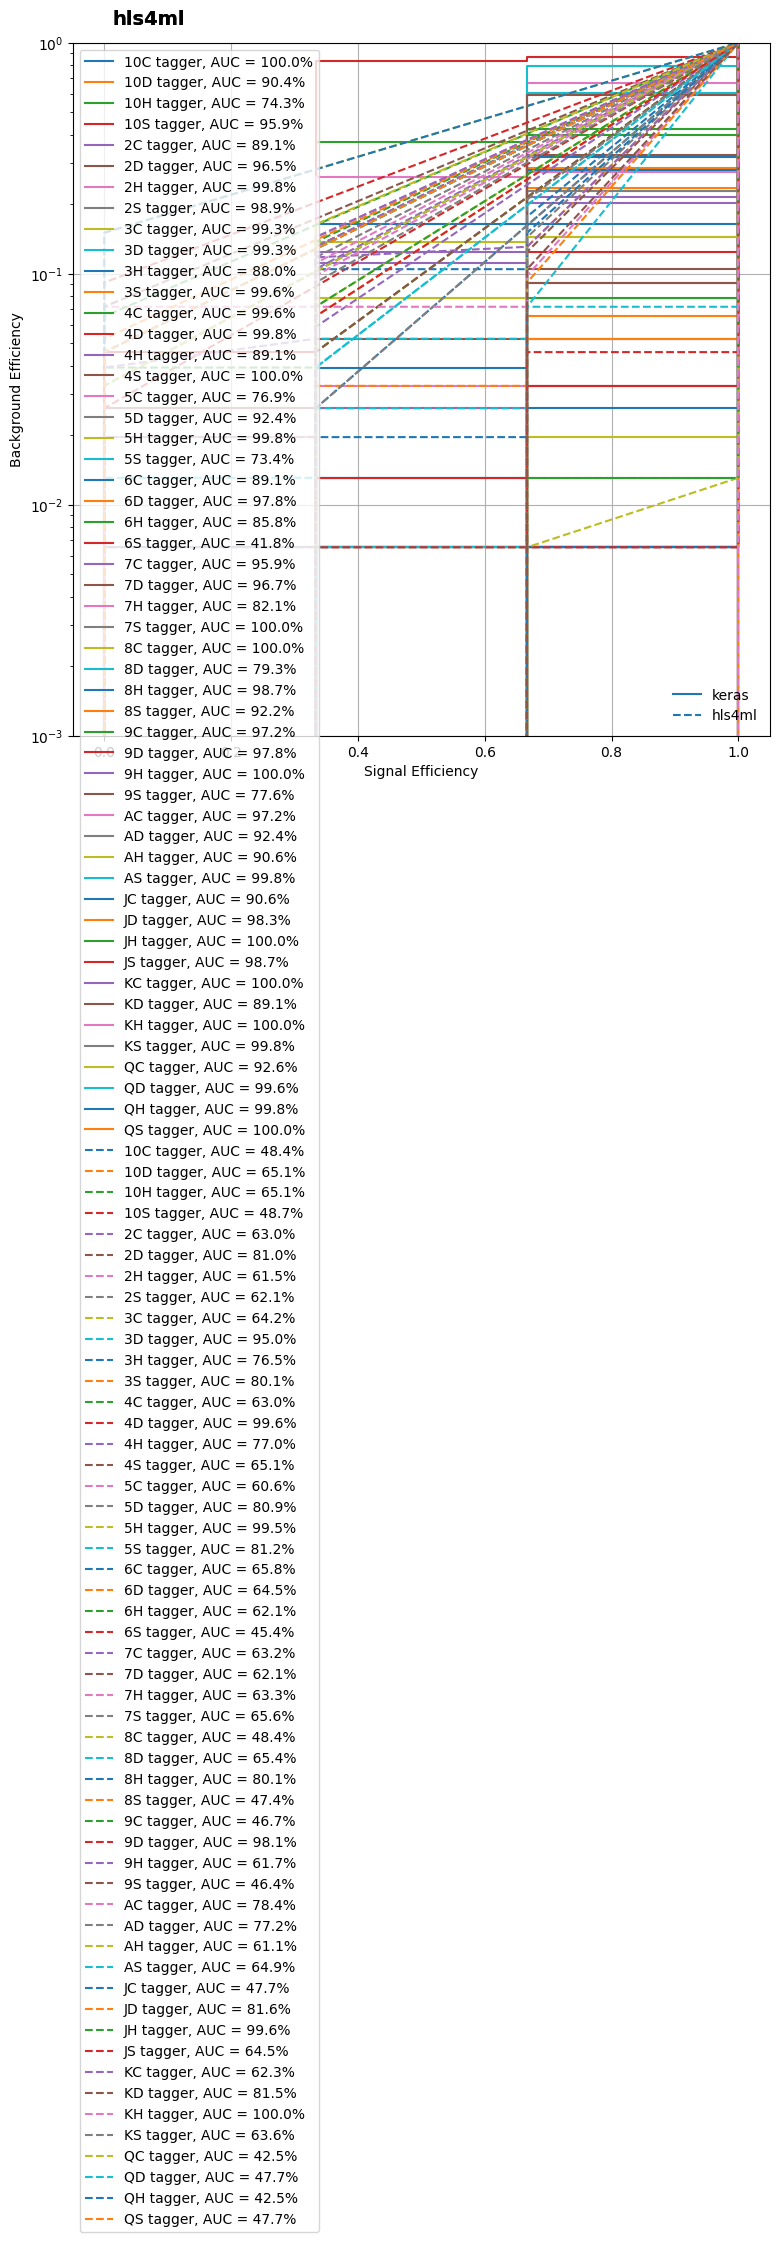

In [29]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, label_encoder.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

Part 2

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import plotting
import os

In [4]:
X_train_val = np.load('X_train_val.npy')
X_test = np.ascontiguousarray(np.load('X_test.npy'))
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

In [5]:
from tensorflow.keras.models import load_model

model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(X_test)

2024-03-21 19:04:43.303553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 14ms/step


In [6]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:         

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

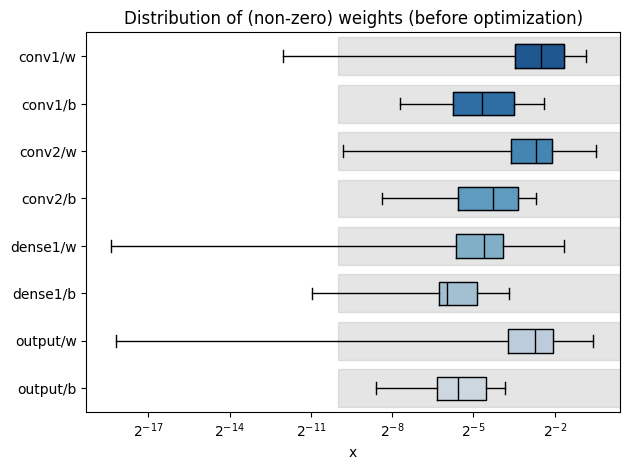

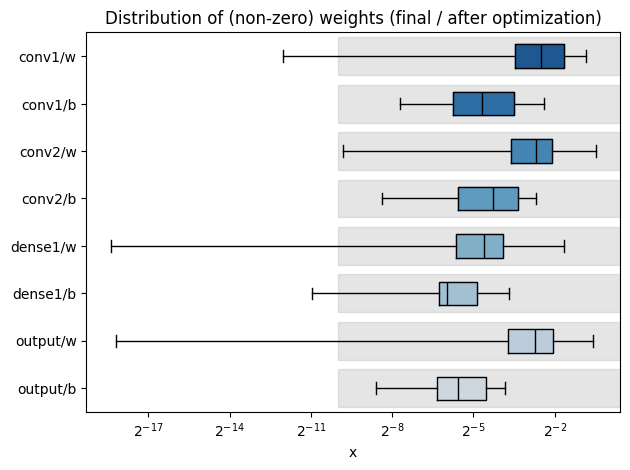

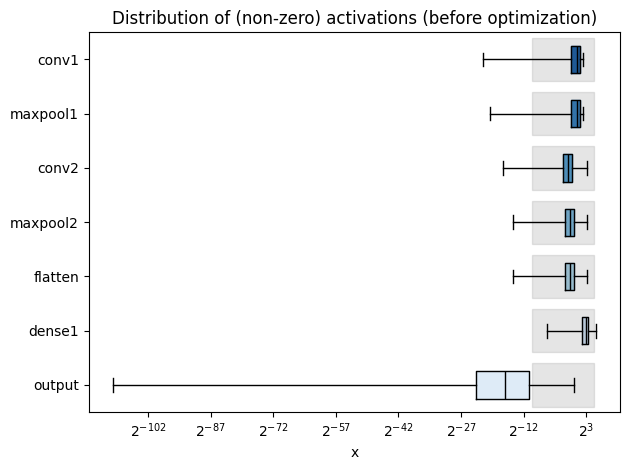

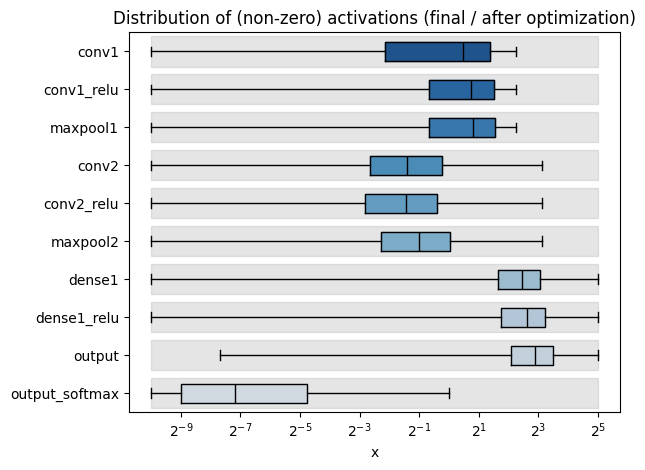

In [7]:
%matplotlib inline
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test[:1000])

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[

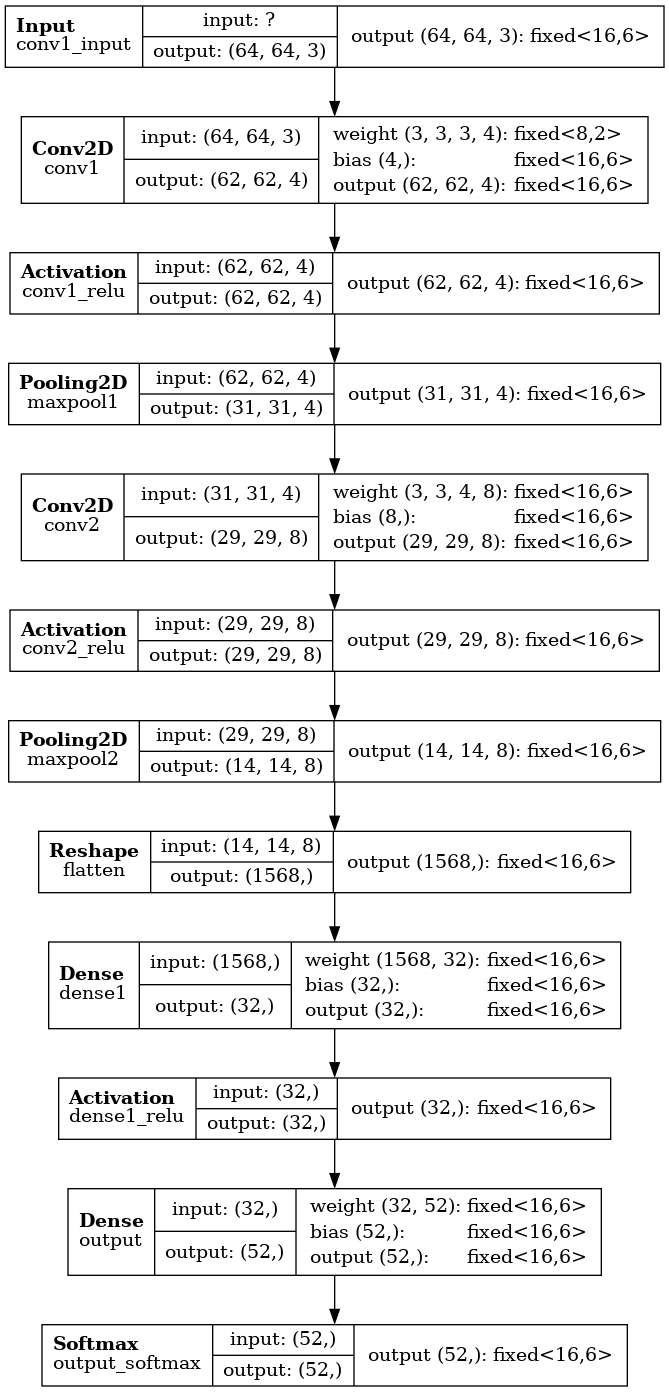

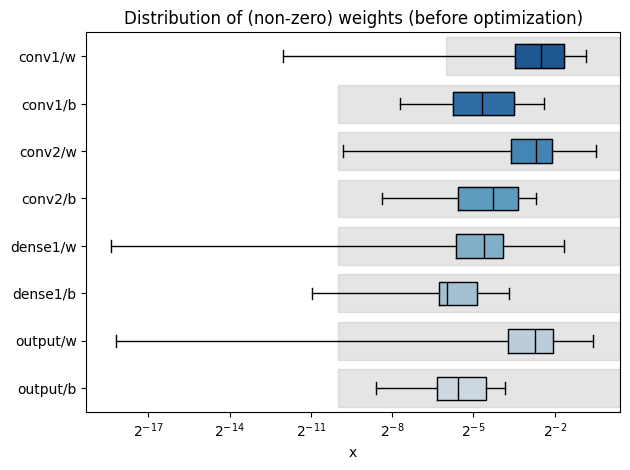

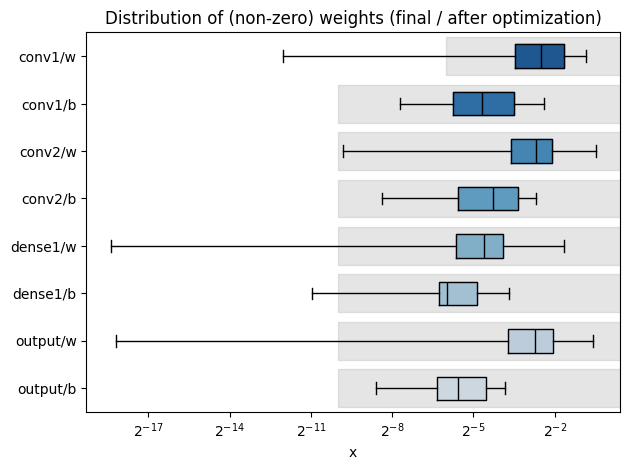

In [8]:
config['LayerName']['conv1']['Precision']['weight'] = 'ap_fixed<8,2>'
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [9]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
Creating HLS model


In [10]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])
y_hls = hls_model.predict(X_test)

Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
5/5 [==============================] - 0s 11ms/step
Done taking outputs for Keras model.


In [11]:
print("Keras layer 'conv1', first sample:")
print(keras_trace['conv1'][0])
print("hls4ml layer 'conv1', first sample:")
print(hls4ml_trace['conv1'][0])

Keras layer 'conv1', first sample:
[[[ 4.4624166  -0.04449563  3.3385365   4.0240264 ]
  [ 4.600567   -0.16440858  3.4125783   4.2745767 ]
  [ 4.6045823  -0.24442784  3.4151156   4.2223516 ]
  ...
  [ 4.7360244  -0.04157667  3.4251328   4.3016086 ]
  [ 4.6108966  -0.07604803  3.250055    4.1290197 ]
  [ 3.9314048   0.26427016  1.8874735   2.9845133 ]]

 [[ 4.686359   -0.24009831  3.4644      4.1999745 ]
  [ 4.7985244  -0.02010821  3.4812305   4.322228  ]
  [ 4.7996054  -0.02668791  3.4481604   4.3381605 ]
  ...
  [ 4.820688   -0.01687233  3.4926405   4.3445888 ]
  [ 4.7301784  -0.00814562  3.3551452   4.254192  ]
  [ 4.3246894  -0.10617433  3.0218432   4.048217  ]]

 [[ 4.7790675  -0.05706854  3.4905107   4.307118  ]
  [ 4.7158737   0.02613294  3.301949    4.346468  ]
  [ 4.3456535   0.49291444  2.6136427   4.2112145 ]
  ...
  [ 4.820688   -0.01687233  3.4926405   4.3445888 ]
  [ 4.820688   -0.01687233  3.4926405   4.3445888 ]
  [ 4.820688   -0.01687233  3.4926405   4.3445888 ]]

 ...


Keras  Accuracy: 0.5641025641025641
hls4ml Accuracy: 0.46153846153846156


/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

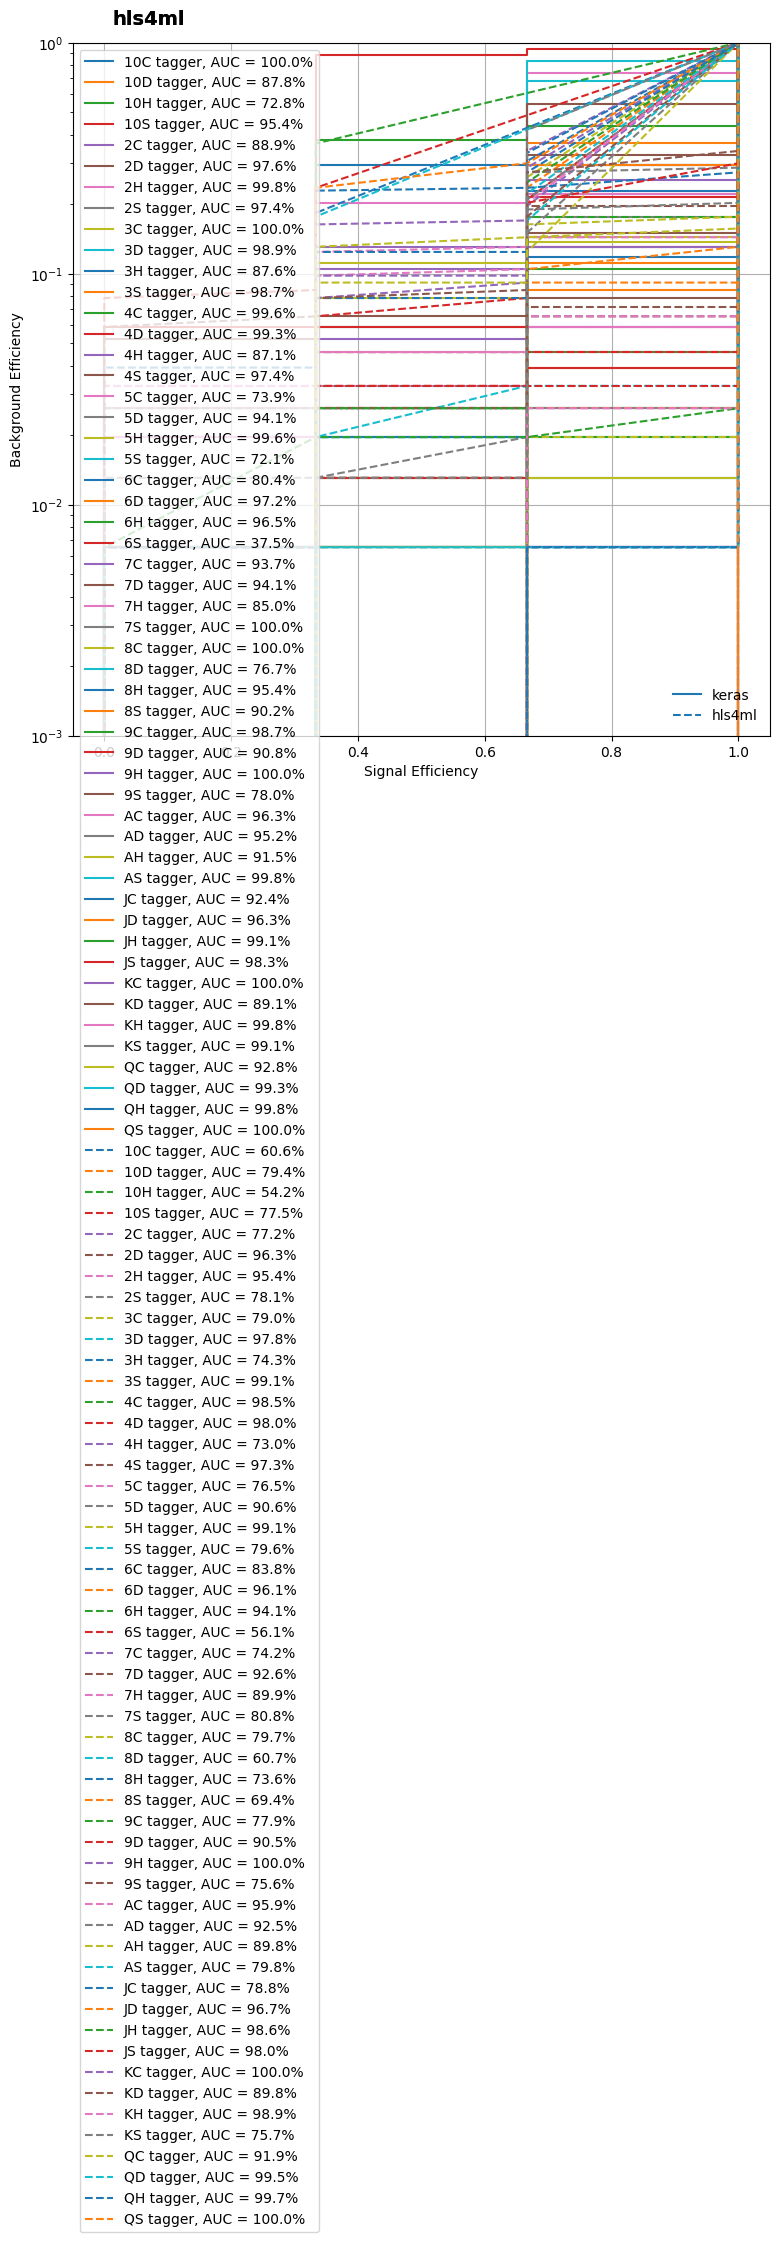

In [14]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

In [15]:
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
print("-----------------------------------")
print(config)
print("-----------------------------------")
# Set the ReuseFactor to 2 throughout
config['Model']['ReuseFactor'] = 2
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls_model.compile()
y_hls = hls_model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'B

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [17]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [23]:
DATA_DIR = "PokerDataset"  
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

In [24]:
model = Sequential()
model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
model.add(Conv2D(8, (3, 3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(Dense(32, activation='relu', name='dense1'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))

In [25]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
train = True
if train:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_2',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_2/KERAS_check_best_model.h5')

Epoch 1/50
43/47 [==========================>...] - ETA: 0s - loss: 3.9644 - accuracy: 0.0116
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 3.94741, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 3.94741, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 4s 21ms/step - loss: 3.9611 - accuracy: 0.0150 - val_loss: 3.9474 - val_accuracy: 0.0321 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 3.9230 - accuracy: 0.0214
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 3.94741 to 3.93110, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 3.94741 to 3.93110, saving model to model_2/KERAS_check_best_model_weight


Epoch 13: saving model to model_2/KERAS_check_model_last.h5

Epoch 13: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 15ms/step - loss: 1.1332 - accuracy: 0.6560 - val_loss: 2.4285 - val_accuracy: 0.3782 - lr: 0.0010
Epoch 14/50
46/47 [============================>.] - ETA: 0s - loss: 1.0113 - accuracy: 0.7239
***callbacks***
saving losses to model_2/losses.log

Epoch 14: val_loss improved from 2.42851 to 2.38880, saving model to model_2/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 2.42851 to 2.38880, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_2/KERAS_check_model_last.h5

Epoch 14: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 15ms/step - loss: 1.0127 - accuracy: 0.7244 - val_loss: 2.3888 - val_accuracy: 0.3718 - lr: 0.0010
Epoch 15/50
46/47 [============================

Epoch 28/50
46/47 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9978
***callbacks***
saving losses to model_2/losses.log

Epoch 28: val_loss did not improve from 2.23299

Epoch 28: val_loss did not improve from 2.23299

Epoch 28: saving model to model_2/KERAS_check_model_last.h5

Epoch 28: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 15ms/step - loss: 0.0656 - accuracy: 0.9979 - val_loss: 2.6115 - val_accuracy: 0.4936 - lr: 5.0000e-04
Epoch 29/50
45/47 [===========================>..] - ETA: 0s - loss: 0.0588 - accuracy: 0.9978
***callbacks***
saving losses to model_2/losses.log

Epoch 29: val_loss did not improve from 2.23299

Epoch 29: val_loss did not improve from 2.23299

Epoch 29: saving model to model_2/KERAS_check_model_last.h5

Epoch 29: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 14ms/step - los


***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0252 - accuracy: 1.0000 - val_loss: 2.8145 - val_accuracy: 0.5321 - lr: 2.5000e-04
Epoch 43/50
44/47 [===========================>..] - ETA: 0s - loss: 7.6587 - accuracy: 0.5932
***callbacks***
saving losses to model_2/losses.log

Epoch 43: val_loss did not improve from 2.23299

Epoch 43: val_loss did not improve from 2.23299

Epoch 43: saving model to model_2/KERAS_check_model_last.h5

Epoch 43: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 15ms/step - loss: 7.5213 - accuracy: 0.5641 - val_loss: 8.0419 - val_accuracy: 0.0962 - lr: 2.5000e-04
Epoch 44/50
47/47 [==============================] - ETA: 0s - loss: 4.3656 - accuracy: 0.1880
***callbacks***
saving losses to model_2/losses.log

Epoch 44: val_loss did not improve from 2.23299

Epoch 44: val_loss did not improve from 2.23299

Epoch 44: saving model to model_2/KERAS_c

% of zeros = 0.75


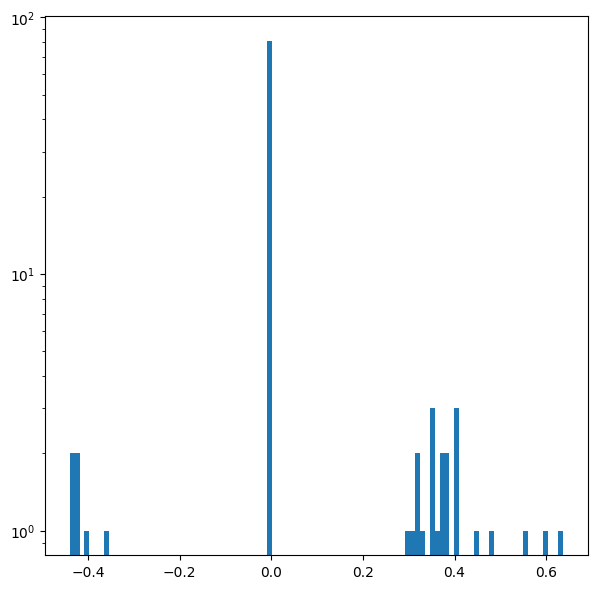

In [27]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

5/5 [==============================] - 0s 8ms/step
Accuracy unpruned: 0.5641025641025641
Accuracy pruned:   0.2564102564102564


/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

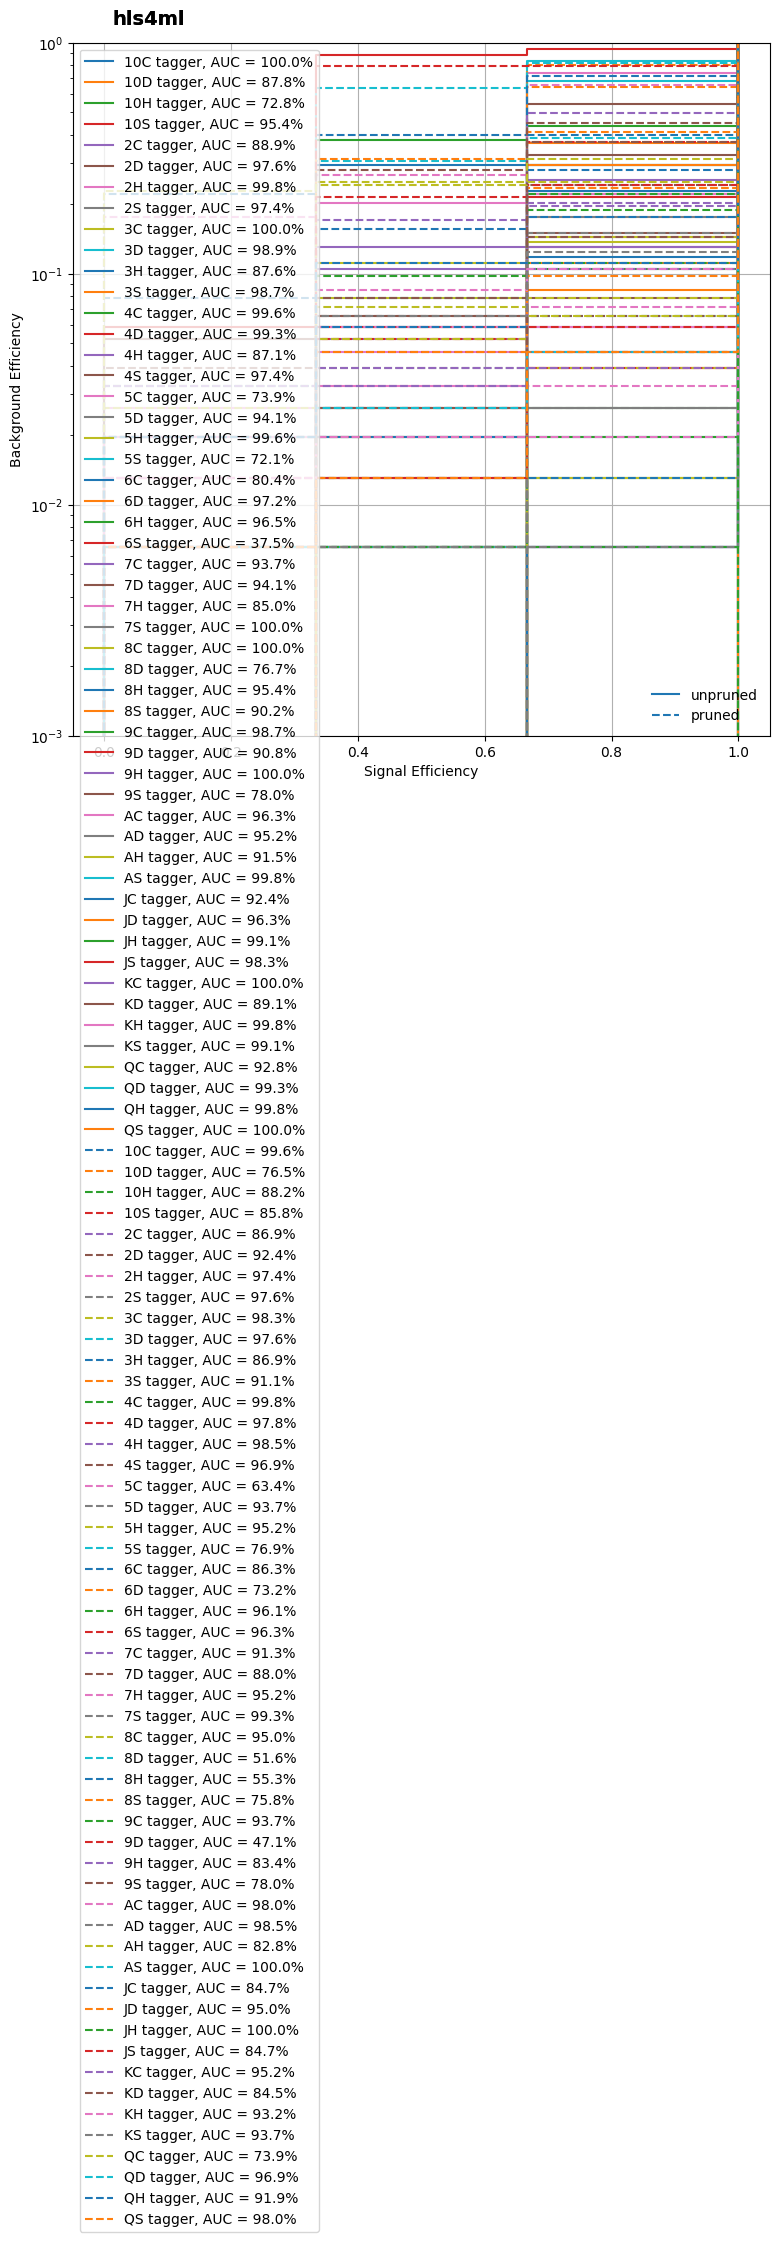

In [28]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['unpruned', 'pruned'], loc='lower right', frameon=False)
ax.add_artist(leg)

In [ ]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
{'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput

Done


Part 4

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [ ]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu